# World Cities Data Analysis: Loading and Initial Exploration

This section focuses on loading the necessary libraries, mounting Google Drive to access the data, loading the dataset into a pandas DataFrame, and performing initial exploratory data analysis (EDA) to understand the structure, data types, and basic quality of the data.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import folium # For interactive maps
import asyncio # For async operations (admin_name fetching)
import aiohttp # For async HTTP requests
import nest_asyncio # To allow asyncio in environments like notebooks
from google.colab import files # For downloading files
from google.colab import sheets # For interactive sheet view

# Mount Google Drive to access files
drive.mount('/content/drive')

# Define the file path for the dataset
# Make sure to adjust this path if your file is located elsewhere in Google Drive
file_path = '/content/drive/MyDrive/Colab Notebooks/World Cities Analysis/worldcities.csv'

# Load the dataset into a pandas DataFrame
try:
    df = pd.read_csv(file_path)
    print(f"Dataset loaded successfully from {file_path}")
except FileNotFoundError:
    print(f"Error: Dataset file not found at {file_path}. Please check the path.")
    # Optionally, stop execution or handle the error appropriately
    # exit()

# --- Initial Data Exploration ---

# Display basic information
print(f"\nOriginal dataset shape: {df.shape[0]} rows, {df.shape[1]} columns")
print("\nFirst 5 rows of the dataset:")
print(df.head())

print("\nData types of each column:")
print(df.dtypes)

# Check for missing values
print("\nMissing values per column:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0]) # Show only columns with missing values

# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"\nNumber of complete duplicate rows: {duplicates}")

# Get summary statistics for numeric columns
print("\nSummary statistics for numeric columns:")
print(df.describe())

# --- Data Quality Checks ---

# Check for potential population outliers (e.g., > 50 million - adjust threshold if needed)
population_threshold = 50_000_000
potential_pop_outliers = df[df['population'] > population_threshold]
print(f"\nPotential population outliers (population > {population_threshold:,}):")
if potential_pop_outliers.empty:
    print("None found.")
else:
    print(potential_pop_outliers[['city', 'country', 'population']])

# Check for potential inconsistencies in country ISO codes (basic check)
print("\nChecking ISO code consistency (basic check):")
iso_mismatch_check = df[df['iso2'].notna() & df['iso3'].notna()].copy()
if not iso_mismatch_check.empty:
    # Check if iso3 starts with iso2 (common pattern, not always true)
    iso_mismatch_check['iso_match_basic'] = iso_mismatch_check.apply(
        lambda x: len(x['iso3']) == 3 and len(x['iso2']) == 2 and x['iso3'].startswith(x['iso2']),
        axis=1
    )
    potential_mismatches = (~iso_mismatch_check['iso_match_basic']).sum()
    print(f"Number of rows with potential basic ISO code mismatches: {potential_mismatches}")
else:
    print("No rows with both iso2 and iso3 to check.")

# Check for invalid latitude/longitude values
print("\nChecking for invalid coordinates:")
invalid_lat = df[(df['lat'] < -90) | (df['lat'] > 90)].shape[0]
invalid_lng = df[(df['lng'] < -180) | (df['lng'] > 180)].shape[0]
print(f"Rows with invalid latitude values (< -90 or > 90): {invalid_lat}")
print(f"Rows with invalid longitude values (< -180 or > 180): {invalid_lng}")

# Examine the distribution of 'capital' types
print("\nDistribution of capital designations:")
print(df['capital'].value_counts(dropna=False)) # Include NaN counts

Mounted at /content/drive
Dataset loaded successfully from /content/drive/MyDrive/Colab Notebooks/World Cities Analysis/worldcities.csv

Original dataset shape: 47868 rows, 11 columns

First 5 rows of the dataset:
        city city_ascii      lat       lng    country iso2 iso3   admin_name  \
0      Tokyo      Tokyo  35.6897  139.6922      Japan   JP  JPN        Tōkyō   
1    Jakarta    Jakarta  -6.1750  106.8275  Indonesia   ID  IDN      Jakarta   
2      Delhi      Delhi  28.6100   77.2300      India   IN  IND        Delhi   
3  Guangzhou  Guangzhou  23.1300  113.2600      China   CN  CHN    Guangdong   
4     Mumbai     Mumbai  19.0761   72.8775      India   IN  IND  Mahārāshtra   

   capital  population          id  
0  primary  37732000.0  1392685764  
1  primary  33756000.0  1360771077  
2    admin  32226000.0  1356872604  
3    admin  26940000.0  1156237133  
4    admin  24973000.0  1356226629  

Data types of each column:
city           object
city_ascii     object
lat        

# Data Cleaning and Preprocessing

This section addresses data quality issues identified during exploration. It includes cleaning text fields, handling duplicates, dropping unnecessary columns, and imputing missing values.

## Text Cleaning, Duplicate Removal, and Column Dropping

In [2]:
# --- Text Cleaning ---
# Convert fully uppercase city names (longer than 3 chars) to title case for consistency
df['city'] = df['city'].apply(
    lambda x: x.title() if isinstance(x, str) and x == x.upper() and len(x) > 3 else x
)

# Convert fully uppercase admin_name (longer than 3 chars) to title case
df['admin_name'] = df['admin_name'].apply(
    lambda x: x.title() if isinstance(x, str) and x == x.upper() and len(x) > 3 else x
)

# --- Duplicate Removal ---
# Remove duplicate entries based on city, country, and admin_name combination
initial_rows = len(df)
df = df.drop_duplicates(subset=['city', 'country', 'admin_name'], keep='first') # Keep the first occurrence
rows_after_dedupe = len(df)
print(f"Removed {initial_rows - rows_after_dedupe} duplicate city entries based on ['city', 'country', 'admin_name']")

# --- Column Dropping ---
# Drop columns that are not needed for the analysis or have high missing values handled elsewhere
columns_to_drop = ['id', 'city_ascii', 'iso2']
df = df.drop(columns=columns_to_drop)
print(f"\nDropped columns: {columns_to_drop}")
print(f"DataFrame shape after initial cleaning: {df.shape}")

Removed 318 duplicate city entries based on ['city', 'country', 'admin_name']

Dropped columns: ['id', 'city_ascii', 'iso2']
DataFrame shape after initial cleaning: (47550, 8)


## Handling Missing Data

Addressing missing values in `population`, `capital`, and `admin_name`.

In [3]:
# --- Impute Specific Missing Values ---
# Fill missing population for 'Charlotte Amalie' based on external knowledge (if applicable)
# Example value used here, replace if you have accurate data
df.loc[df['city'] == 'Charlotte Amalie', 'population'] = 10354
print("Filled missing population for Charlotte Amalie (example)")

# --- Impute Categorical Missing Values ---
# Fill missing 'capital' values with 'Not Capital'
capital_missing_before = df['capital'].isnull().sum()
df['capital'] = df['capital'].fillna('Not Capital')
print(f"Filled {capital_missing_before} missing 'capital' values with 'Not Capital'")

# --- Impute Numeric Missing Values (Population) ---
# Keep track of which population values were originally null
pop_null_mask = df['population'].isnull()
pop_missing_count = pop_null_mask.sum()

# Calculate country-wise average population (excluding NaNs for the mean calculation)
country_avg_pop = df.groupby('country')['population'].transform('mean')

# Impute missing populations using the calculated country average
df.loc[pop_null_mask, 'population'] = country_avg_pop[pop_null_mask]
print(f"Imputed {pop_missing_count} missing 'population' values using country averages.")

# --- Final Population Type Conversion ---
# Convert population to integer type. Handle any remaining NaNs (e.g., if a country had no non-NaN populations)
# by filling them with 0 before conversion, although these should be minimal after imputation.
remaining_pop_nan = df['population'].isnull().sum()
if remaining_pop_nan > 0:
    print(f"Warning: {remaining_pop_nan} population NaNs remaining after imputation. Filling with 0.")
    df['population'] = df['population'].fillna(0)

df['population'] = df['population'].astype(int)
print("Converted 'population' column to integer type.")

# Add a flag for estimated populations
df['population_estimated'] = pop_null_mask # Reuse the mask created before imputation
print("Added 'population_estimated' flag column.")

Filled missing population for Charlotte Amalie (example)
Filled 34544 missing 'capital' values with 'Not Capital'
Imputed 204 missing 'population' values using country averages.
Converted 'population' column to integer type.
Added 'population_estimated' flag column.


## Handling Population Data (Outliers and Zeroes)

Further processing of the population column, including converting to numeric (if not already done), flagging potential outliers, and removing cities with zero population.

In [4]:
# Ensure population is numeric (might be redundant but safe)
df['population'] = pd.to_numeric(df['population'], errors='coerce')

# Flag potentially unrealistic high populations (e.g., > 50 Million)
# Note: This check is done *after* imputation and initial cleaning.
unrealistic_pop_threshold = 50_000_000
population_outliers = df[df['population'] > unrealistic_pop_threshold]
if not population_outliers.empty:
    print(f"\nWarning: Found {len(population_outliers)} cities with potentially unrealistic high populations (> {unrealistic_pop_threshold:,}):")
    print(population_outliers[['city', 'country', 'population']])
else:
    print(f"\nNo cities found with population > {unrealistic_pop_threshold:,}.")

# Remove cities with 0 population (likely data errors or uninhabited places)
rows_before_zero_removal = len(df)
df = df[df['population'] > 0] # Keep only rows where population is greater than 0
rows_after_zero_removal = len(df)
print(f"Removed {rows_before_zero_removal - rows_after_zero_removal} cities with zero population.")
print(f"DataFrame shape after zero population removal: {df.shape}")


No cities found with population > 50,000,000.
Removed 4 cities with zero population.
DataFrame shape after zero population removal: (47546, 9)


## Feature Engineering: Add Population Categories (Binning)

Creating a categorical feature based on population size to facilitate analysis.

In [5]:
# Define population bins and corresponding labels
# Bins: (0, 100k], (100k, 1M], (1M, 10M], (10M, max]
max_population = df['population'].max() # Get the maximum population for the upper bin edge
bins = [0, 100000, 1000000, 10000000, max_population]
labels = ['Small', 'Medium', 'Large', 'Mega']

# Create the 'population_category' column using pd.cut
# include_lowest=True ensures that the minimum value (if it matches the lowest bin edge) is included.
df['population_category'] = pd.cut(df['population'], bins=bins, labels=labels, include_lowest=True, right=True)

print("\nCreated 'population_category' column.")
print("Value counts for population categories:")
print(df['population_category'].value_counts())


Created 'population_category' column.
Value counts for population categories:
population_category
Small     41348
Medium     5427
Large       728
Mega         43
Name: count, dtype: int64


## Handling Missing Data: `admin_name` Imputation using Geolocation

Using the Nominatim API (via `aiohttp` for asynchronous requests) to fill missing `admin_name` values based on latitude and longitude coordinates. This provides more accurate administrative region information than simply using the country name.

**Install necessary libraries (if not already installed)**

*Note: `aiohttp`, `asyncio`, and `nest_asyncio` were imported earlier. This cell is kept for reference if running parts independently.*

In [6]:
# Ensure necessary libraries for async operations are installed
# These were imported at the beginning, but this ensures they are present
# !pip install aiohttp nest_asyncio -q # -q for quiet installation
print("Libraries aiohttp, asyncio, nest_asyncio assumed to be imported.")

Libraries aiohttp, asyncio, nest_asyncio assumed to be imported.


**Fetch `admin_name` data using Nominatim API**

In [7]:
# --- Fetch Missing admin_name using Geolocation ---

# Select rows where admin_name is currently missing
missing_admin_df = df[df['admin_name'].isna()].copy() # Use .copy() to avoid SettingWithCopyWarning
num_missing_admin = len(missing_admin_df)
print(f"Attempting to fetch {num_missing_admin} missing 'admin_name' values using geolocation...")

async def fetch_admin_name(session, lat, lng, index):
    """Asynchronously fetches admin_name for a given latitude and longitude."""
    # Nominatim API endpoint for reverse geocoding
    url = f"https://nominatim.openstreetmap.org/reverse?format=json&lat={lat}&lon={lng}&addressdetails=1"
    # Set a descriptive User-Agent as required by Nominatim's usage policy
    headers = {'User-Agent': 'WorldCitiesAnalysisNotebook/1.0 (colab)'}
    try:
        # Make the asynchronous GET request
        async with session.get(url, headers=headers, timeout=10) as response: # Added timeout
            if response.status == 200:
                data = await response.json()
                address = data.get('address', {})
                # Try to get state, county, or region, falling back to country if necessary
                admin_name = address.get('state') or address.get('county') or address.get('region') or address.get('country')
                return index, admin_name
            else:
                # Print error if the request failed
                print(f"Request failed for index {index} ({lat},{lng}) with status {response.status}")
                return index, None
    except asyncio.TimeoutError:
        print(f"Request timed out for index {index} ({lat},{lng})")
        return index, None
    except Exception as e:
        # Print any other exceptions that occur
        print(f"Exception for index {index} ({lat},{lng}): {e}")
        return index, None

async def fetch_all_admin_names(locations_df, delay=1.1):
    """Manages multiple asynchronous requests with a delay between each."""
    results = {}
    # Create an asynchronous HTTP client session
    async with aiohttp.ClientSession() as session:
        tasks = []
        # Create a list of tasks to run concurrently (respecting delay)
        for i, (idx, row) in enumerate(locations_df.iterrows()):
            task = asyncio.ensure_future(fetch_admin_name(session, row['lat'], row['lng'], idx))
            tasks.append(task)
            # Apply delay to avoid overwhelming the API
            if (i + 1) % 10 == 0: # Optional: print progress
                 print(f"Scheduled {i+1}/{len(locations_df)} requests...")
            await asyncio.sleep(delay)

        # Wait for all tasks to complete and gather results
        print("\nWaiting for requests to complete...")
        fetched_results = await asyncio.gather(*tasks)
        # Store results in a dictionary {index: admin_name}
        for index, admin_name in fetched_results:
             if admin_name: # Only store if a name was found
                 results[index] = admin_name
    return results

# Apply nest_asyncio to allow running asyncio event loop within the notebook
nest_asyncio.apply()

# Run the asynchronous fetching process if there are missing values
fetched_admin_names = {}
if num_missing_admin > 0:
    fetched_admin_names = asyncio.run(fetch_all_admin_names(missing_admin_df))
    print(f"\nFetched {len(fetched_admin_names)} admin names.")
else:
    print("No missing 'admin_name' values to fetch.")

# --- Fill Results Back into DataFrame ---
# Update the original DataFrame with the fetched admin names
if fetched_admin_names:
    for idx, admin_name in fetched_admin_names.items():
        df.loc[idx, 'admin_name'] = admin_name
    print(f"Updated DataFrame with {len(fetched_admin_names)} fetched admin names.")

# --- Fallback Imputation ---
# For any remaining missing admin_names (e.g., API failures), fill with the country name
admin_still_missing = df['admin_name'].isnull().sum()
if admin_still_missing > 0:
    print(f"Filling {admin_still_missing} remaining missing 'admin_name' values with the country name.")
    df['admin_name'] = df['admin_name'].fillna(df['country'])

# Final check for missing admin_name values
final_admin_missing = df['admin_name'].isnull().sum()
print(f"\nFinal count of missing 'admin_name' values: {final_admin_missing}")

Attempting to fetch 196 missing 'admin_name' values using geolocation...
Scheduled 10/196 requests...
Scheduled 20/196 requests...
Scheduled 30/196 requests...
Scheduled 40/196 requests...
Scheduled 50/196 requests...
Scheduled 60/196 requests...
Scheduled 70/196 requests...
Scheduled 80/196 requests...
Scheduled 90/196 requests...
Scheduled 100/196 requests...
Scheduled 110/196 requests...
Scheduled 120/196 requests...
Scheduled 130/196 requests...
Scheduled 140/196 requests...
Scheduled 150/196 requests...
Scheduled 160/196 requests...
Scheduled 170/196 requests...
Scheduled 180/196 requests...
Scheduled 190/196 requests...

Waiting for requests to complete...

Fetched 196 admin names.
Updated DataFrame with 196 fetched admin names.

Final count of missing 'admin_name' values: 0


## Data Validation: Coordinate Clamping

Ensuring latitude and longitude values are strictly within their valid theoretical ranges.

In [8]:
# Ensure latitude and longitude are within valid ranges
# Clamp latitude values between -90 and 90
df['lat'] = df['lat'].clip(lower=-90, upper=90)
# Clamp longitude values between -180 and 180
df['lng'] = df['lng'].clip(lower=-180, upper=180)

print("Clamped latitude and longitude values to their valid ranges.")

Clamped latitude and longitude values to their valid ranges.


## Create Cleaned DataFrame Copy

Creating a final copy of the processed DataFrame for clarity before export and further analysis.

In [9]:
# Create a final cleaned DataFrame (can be the same df if preferred)
cleaned_df = df.copy()
print("Created cleaned_df as a copy of the processed DataFrame.")

Created cleaned_df as a copy of the processed DataFrame.


## Final Data Quality Check

Verifying that there are no remaining null values in the cleaned dataset.

In [10]:
# Final check for null values in the cleaned DataFrame
print("\nFinal check for missing values in cleaned_df:")
final_missing = cleaned_df.isnull().sum()
print(final_missing)
if final_missing.sum() == 0:
    print("\nNo missing values found in the cleaned dataset. 👍")
else:
    print("\nWarning: Missing values still present in the cleaned dataset.")


Final check for missing values in cleaned_df:
city                    0
lat                     0
lng                     0
country                 0
iso3                    0
admin_name              0
capital                 0
population              0
population_estimated    0
population_category     0
dtype: int64

No missing values found in the cleaned dataset. 👍


## Interactive Data Preview

Using Google Colab's interactive sheet feature for a quick, scrollable view of the cleaned data.

In [11]:
# Display an interactive sheet view of the cleaned DataFrame
print("Generating interactive sheet preview (may take a moment)...")
sheets.InteractiveSheet(df = cleaned_df)

Generating interactive sheet preview (may take a moment)...
https://docs.google.com/spreadsheets/d/1tFR1x2sUZPq_wbcmbDHJgFRgGlRrpAZD3_81Ny096NI/edit#gid=0


## Export Cleaned Data

Saving the processed DataFrame to a new CSV file and providing a download link.

In [12]:
# Define the output filename
output_filename = 'cleaned_worldcities.csv'

# Save the cleaned DataFrame to a CSV file, without the index column
cleaned_df.to_csv(output_filename, index=False)
print(f"Cleaned data saved to {output_filename}")

# Trigger download of the CSV file in the Colab environment
print("Initiating file download...")
files.download(output_filename)

Cleaned data saved to cleaned_worldcities.csv
Initiating file download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Exploratory Data Analysis (EDA) on Cleaned Data

Performing EDA on the newly cleaned dataset to uncover patterns and insights.

Cleaned dataset 'cleaned_worldcities.csv' loaded for EDA.

--- EDA on Cleaned Data ---

First 5 rows:
        city      lat       lng    country iso3   admin_name  capital  \
0      Tokyo  35.6897  139.6922      Japan  JPN        Tōkyō  primary   
1    Jakarta  -6.1750  106.8275  Indonesia  IDN      Jakarta  primary   
2      Delhi  28.6100   77.2300      India  IND        Delhi    admin   
3  Guangzhou  23.1300  113.2600      China  CHN    Guangdong    admin   
4     Mumbai  19.0761   72.8775      India  IND  Mahārāshtra    admin   

   population  population_estimated population_category  
0    37732000                 False                Mega  
1    33756000                 False                Mega  
2    32226000                 False                Mega  
3    26940000                 False                Mega  
4    24973000                 False                Mega  

Summary statistics (numeric columns):
                lat           lng    population
count  47546.000000  475

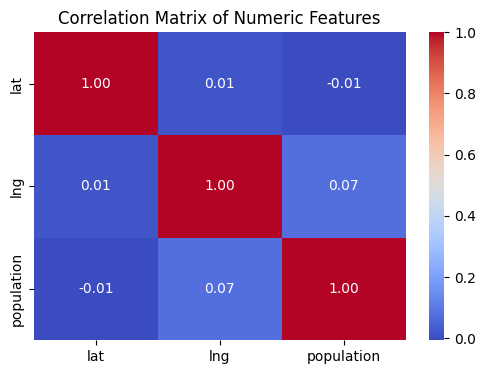

In [13]:
# --- EDA Setup ---
# It's good practice to reload the cleaned data to ensure we're working with the final version
cleaned_file_path = 'cleaned_worldcities.csv'
try:
    df_eda = pd.read_csv(cleaned_file_path)
    print(f"Cleaned dataset '{cleaned_file_path}' loaded for EDA.")
except FileNotFoundError:
    print(f"Error: Cleaned file '{cleaned_file_path}' not found. Using 'cleaned_df' from memory.")
    df_eda = cleaned_df.copy() # Fallback to the DataFrame in memory

# --- Basic Exploration (Cleaned Data) ---
print("\n--- EDA on Cleaned Data ---")
print("\nFirst 5 rows:")
print(df_eda.head())

print("\nSummary statistics (numeric columns):")
print(df_eda.describe())

print("\nInfo (data types and non-null counts):")
df_eda.info()

# Re-check for nulls and duplicates (should be none)
print("\nMissing values check:")
print(df_eda.isnull().sum().sum()) # Total missing values
print("\nDuplicate rows check:")
print(df_eda.duplicated().sum())

# --- Deeper Exploration ---
print("\nNumber of unique countries:")
print(df_eda['country'].nunique())

print("\nNumber of cities per country (Top 15):")
print(df_eda['country'].value_counts().head(15))

print("\nDistribution of population categories:")
print(df_eda['population_category'].value_counts(normalize=True) * 100) # Show percentages

print("\nDistribution of capital types:")
print(df_eda['capital'].value_counts())

# Correlation between numeric features (Latitude, Longitude, Population)
print("\nCorrelation matrix (numeric features):")
numeric_cols = ['lat', 'lng', 'population']
correlation_matrix = df_eda[numeric_cols].corr()
print(correlation_matrix)

# Visualize the correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.show()

# Data Visualization

Creating visual representations of the data to highlight key findings and distributions.

## 1. Top 10 Countries with the Most Cities

Visualizing the countries that appear most frequently in the dataset.

<ipython-input-14-60a54ea16e33>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_countries_by_city_count.index, y=top_10_countries_by_city_count.values, palette='viridis')


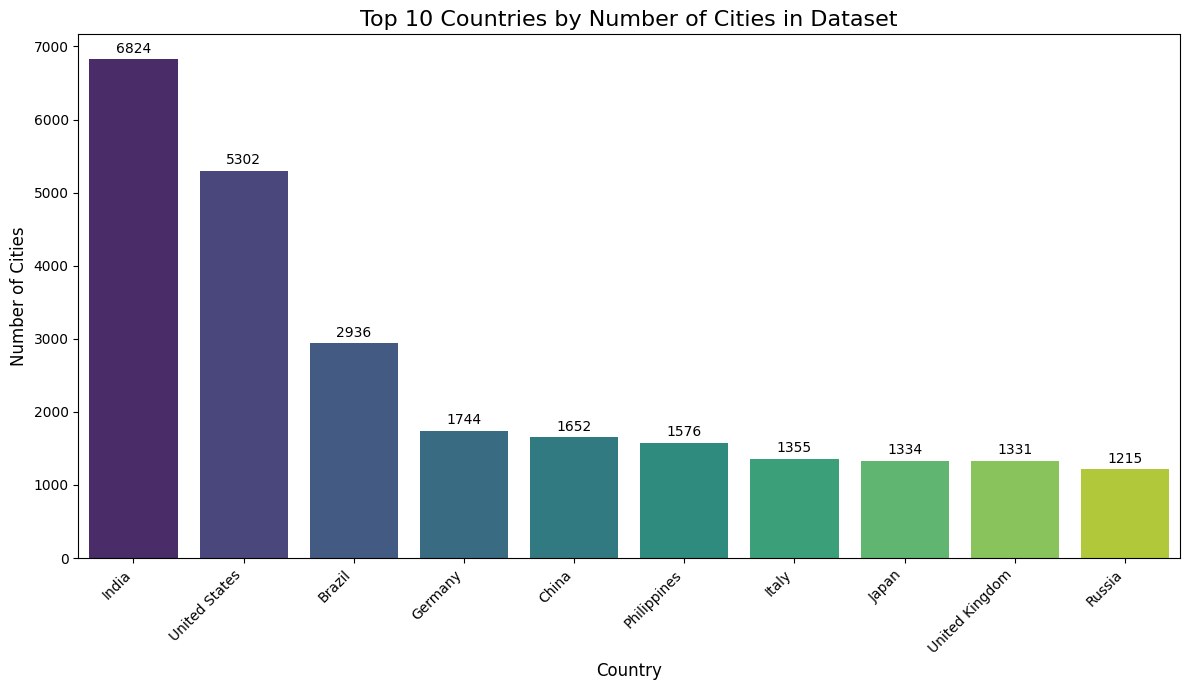

In [14]:
# Get the value counts for countries and select the top 10
top_10_countries_by_city_count = df_eda['country'].value_counts().head(10)

# Create the bar plot
plt.figure(figsize=(12, 7)) # Adjusted figure size for better label visibility
sns.barplot(x=top_10_countries_by_city_count.index, y=top_10_countries_by_city_count.values, palette='viridis')

# Add titles and labels
plt.title('Top 10 Countries by Number of Cities in Dataset', fontsize=16)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Number of Cities', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right') # Adjusted rotation and alignment

# Add data labels on top of bars
for index, value in enumerate(top_10_countries_by_city_count.values):
    plt.text(index, value + 50, str(value), ha='center', va='bottom', fontsize=10) # Adjust offset as needed

# Improve layout and display the plot
plt.tight_layout()
plt.show()

## 2. Top 10 Most Populated Cities

Visualizing the cities with the highest recorded populations.

<ipython-input-15-c18c5976b539>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_populated_cities['population'], y=top_10_populated_cities['city'], palette='magma', orient='h') # Horizontal bar plot


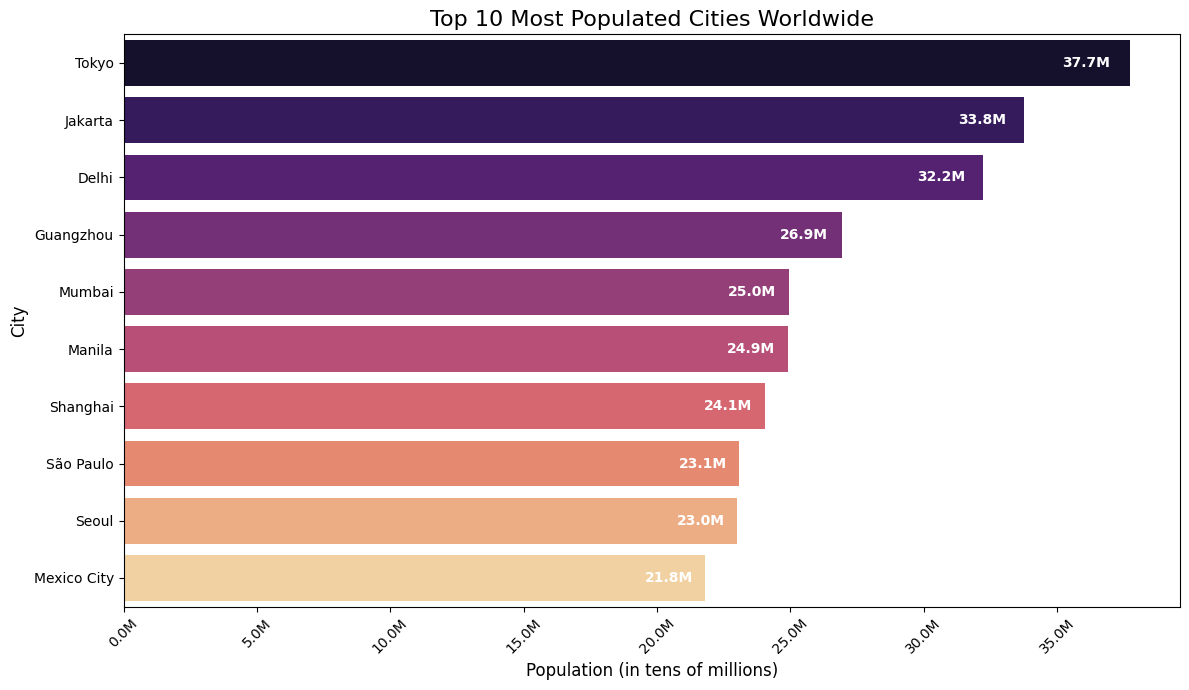

In [15]:
# Select top 10 most populated cities, ensuring population is numeric and dropping NaNs
df_eda['population'] = pd.to_numeric(df_eda['population'], errors='coerce')
top_10_populated_cities = df_eda.dropna(subset=['population']).sort_values(by='population', ascending=False).head(10)

# Create the bar plot
plt.figure(figsize=(12, 7))
sns.barplot(x=top_10_populated_cities['population'], y=top_10_populated_cities['city'], palette='magma', orient='h') # Horizontal bar plot

# Add titles and labels
plt.title('Top 10 Most Populated Cities Worldwide', fontsize=16)
plt.xlabel('Population (in tens of millions)', fontsize=12)
plt.ylabel('City', fontsize=12)

# Format x-axis for better readability (e.g., show in millions)
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='x') # Avoid scientific notation
ax = plt.gca()
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x / 1_000_000:.1f}M'))

# Add data labels inside bars for horizontal plot
for index, value in enumerate(top_10_populated_cities['population']):
    plt.text(value * 0.98, index , f'{value / 1_000_000:.1f}M', ha='right', va='center', color='white', fontsize=10, fontweight='bold') # Adjust position/style

# Improve layout and display the plot
plt.tight_layout()
plt.show()

## 3. Interactive World Map of All Cities 🌍

Creating an interactive map using Folium to visualize the geographic distribution of all cities in the cleaned dataset.

In [16]:
# --- Create Interactive Map (All Cities) ---
print("Generating interactive map for all cities (worldcities_map.html)... This might take a while.")

# Create a base map centered roughly in the middle of the world
world_map_all = folium.Map(location=[20, 0], zoom_start=2, tiles='CartoDB positron') # Using a lighter tile theme

# Add cities to the map using CircleMarkers for better performance with many points
# Use a subset for quicker map generation if needed (e.g., df_eda.sample(5000))
city_subset = df_eda.dropna(subset=['lat', 'lng']) # Ensure no NaNs in coordinates

for idx, row in city_subset.iterrows():
    # Create popup text with relevant information
    popup_text = f"<b>City:</b> {row['city']}<br>"
    popup_text += f"<b>Country:</b> {row['country']}<br>"
    if pd.notna(row['admin_name']): # Check if admin_name exists
        popup_text += f"<b>Admin:</b> {row['admin_name']}<br>"
    popup_text += f"<b>Population:</b> {int(row['population']):,}<br>"
    popup_text += f"<b>Category:</b> {row['population_category']}"

    folium.CircleMarker(
        location=[row['lat'], row['lng']],
        radius=2, # Smaller radius for many points
        popup=folium.Popup(popup_text, max_width=250),
        color='#3186cc', # Blue color
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7
    ).add_to(world_map_all)

# Define the output map filename
map_all_filename = 'worldcities_map.html'
# Save the map to an HTML file
world_map_all.save(map_all_filename)
print(f"Interactive map saved to {map_all_filename}")

# Optional: Display the map inline in Colab (might be slow/crash with too many points)
# print("Displaying map inline (may be slow)...")
# world_map_all

Generating interactive map for all cities (worldcities_map.html)... This might take a while.
Interactive map saved to worldcities_map.html


## 4. Cities with Largest and Smallest Populations

Identifying and mapping the cities with the extreme population values in the dataset.

In [17]:
# --- Find Largest and Smallest Population Cities ---

# Ensure population is numeric and drop NaNs (if any remained, though unlikely after cleaning)
df_eda['population'] = pd.to_numeric(df_eda['population'], errors='coerce')
df_nonull_eda = df_eda.dropna(subset=['population'])

# Find the city with the largest population
largest_city = df_nonull_eda.loc[df_nonull_eda['population'].idxmax()]
print("🌟 City with Largest Population:")
print(largest_city[['city', 'country', 'admin_name', 'population', 'lat', 'lng']])
print("-" * 50)

# Find the city with the smallest population (greater than 0)
smallest_city = df_nonull_eda[df_nonull_eda['population'] > 0].loc[df_nonull_eda['population'].idxmin()]
print("🏡 City with Smallest Population (>0):")
print(smallest_city[['city', 'country', 'admin_name', 'population', 'lat', 'lng']])

🌟 City with Largest Population:
city             Tokyo
country          Japan
admin_name       Tōkyō
population    37732000
lat            35.6897
lng           139.6922
Name: 0, dtype: object
--------------------------------------------------
🏡 City with Smallest Population (>0):
city            Sabhā
country         Libya
admin_name      Sabhā
population          2
lat           27.0389
lng           14.4264
Name: 47341, dtype: object


**Map Key:**
* Red marker 🔴 → Largest city
* Blue marker 🔵 → Smallest city

In [18]:
# --- Create Map for Largest/Smallest Cities ---
print("Generating interactive map for largest/smallest cities (extreme_cities_map.html)...")

# Create a base map centered roughly between the two cities
center_lat_ext = (largest_city['lat'] + smallest_city['lat']) / 2
center_lon_ext = (largest_city['lng'] + smallest_city['lng']) / 2

# Initialize the map
map_extremes = folium.Map(location=[center_lat_ext, center_lon_ext], zoom_start=2, tiles='CartoDB positron')

# Add Largest City Marker (Red)
popup_largest = f"<b>Largest City:</b> {largest_city['city']} ({largest_city['country']})<br><b>Population:</b> {int(largest_city['population']):,}"
folium.Marker(
    location=[largest_city['lat'], largest_city['lng']],
    popup=folium.Popup(popup_largest, max_width=250),
    icon=folium.Icon(color='red', icon='star') # Using star icon
).add_to(map_extremes)

# Add Smallest City Marker (Blue)
popup_smallest = f"<b>Smallest City:</b> {smallest_city['city']} ({smallest_city['country']})<br><b>Population:</b> {int(smallest_city['population']):,}"
folium.Marker(
    location=[smallest_city['lat'], smallest_city['lng']],
    popup=folium.Popup(popup_smallest, max_width=250),
    icon=folium.Icon(color='blue', icon='info-sign')
).add_to(map_extremes)

# Define the output map filename
map_extremes_filename = 'extreme_cities_map.html'
# Save the map
map_extremes.save(map_extremes_filename)
print(f"Interactive map saved to {map_extremes_filename}")

# Display the map inline in Colab
map_extremes

Generating interactive map for largest/smallest cities (extreme_cities_map.html)...
Interactive map saved to extreme_cities_map.html


## 5. Country-Level Insights

Aggregating data at the country level to find countries with the most cities, highest total population, and highest average city population.

In [19]:
# --- Country-Level Aggregations ---

# Group the DataFrame by country
country_grouped = df_nonull_eda.groupby('country')

# 1. Country with the most cities in the dataset
country_city_counts = country_grouped.size().sort_values(ascending=False)
most_cities_country = country_city_counts.head(1)
print("🏙️ Country with the Most Cities:")
print(most_cities_country)
print("-" * 50)

# 2. Country with the highest total population across its listed cities
country_total_population = country_grouped['population'].sum().sort_values(ascending=False)
highest_total_pop_country = country_total_population.head(1)
print("🌏 Country with Highest Total City Population:")
print(f"{highest_total_pop_country.index[0]}: {highest_total_pop_country.values[0]:,}")
print("-" * 50)

# 3. Country with the highest average city population
country_avg_population = country_grouped['population'].mean().sort_values(ascending=False)
highest_avg_pop_country = country_avg_population.head(1)
print("📊 Country with Highest Average City Population:")
print(f"{highest_avg_pop_country.index[0]}: {highest_avg_pop_country.values[0]:,.0f}")
print("-" * 50)

# 4. Countries with average city population > 1 million
high_avg_pop_countries = country_avg_population[country_avg_population > 1_000_000]
print("🏆 Countries with Average City Population > 1 Million:")
if high_avg_pop_countries.empty:
    print("None found.")
else:
    print(high_avg_pop_countries.apply(lambda x: f"{x:,.0f}")) # Format output

🏙️ Country with the Most Cities:
country
India    6824
dtype: int64
--------------------------------------------------
🌏 Country with Highest Total City Population:
China: 1,403,084,181
--------------------------------------------------
📊 Country with Highest Average City Population:
Singapore: 5,983,000
--------------------------------------------------
🏆 Countries with Average City Population > 1 Million:
country
Singapore    5,983,000
Name: population, dtype: object


## 6. Population Distribution Analysis

Analyzing the distribution of population sizes and the contribution of the largest cities to the total population.

🌆 Top 10 Most Populous Cities and their Percentage of Total Dataset Population:
          city       country  population pop_percentage
0        Tokyo         Japan  37,732,000          0.72%
1      Jakarta     Indonesia  33,756,000          0.65%
2        Delhi         India  32,226,000          0.62%
3    Guangzhou         China  26,940,000          0.52%
4       Mumbai         India  24,973,000          0.48%
5       Manila   Philippines  24,922,000          0.48%
6     Shanghai         China  24,073,000          0.46%
7    São Paulo        Brazil  23,086,000          0.44%
8        Seoul  Korea, South  23,016,000          0.44%
9  Mexico City        Mexico  21,804,000          0.42%


<ipython-input-20-dedd71ae0906>:57: UserWarning: Glyph 127750 (\N{CITYSCAPE AT DUSK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127750 (\N{CITYSCAPE AT DUSK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


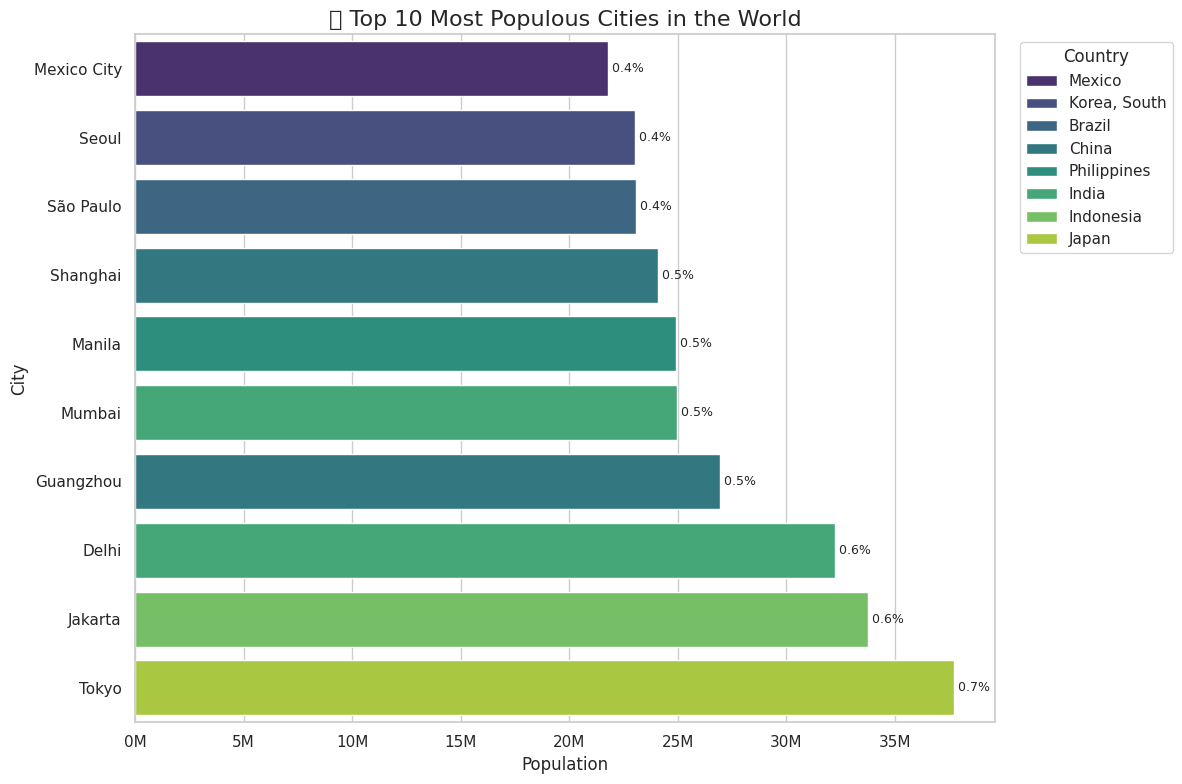

In [20]:
# --- Population Distribution Analysis ---

# Ensure population is numeric and drop NaNs (using df_nonull_eda from previous step)

# Top 10 most populous cities
top_10_populous = df_nonull_eda.sort_values(by='population', ascending=False).head(10)

# Calculate total population for percentage calculation
total_population_all_cities = df_nonull_eda['population'].sum()

# Add population percentage column to the top 10 DataFrame
top_10_populous['pop_percentage'] = (top_10_populous['population'] / total_population_all_cities * 100)

print("🌆 Top 10 Most Populous Cities and their Percentage of Total Dataset Population:")
# Select and format columns for display
top_10_display = top_10_populous[['city', 'country', 'population', 'pop_percentage']].copy()
top_10_display['population'] = top_10_display['population'].map('{:,.0f}'.format)
top_10_display['pop_percentage'] = top_10_display['pop_percentage'].map('{:.2f}%'.format)
print(top_10_display)

# --- Visualization: Top 10 Populous Cities Bar Chart ---

# Set seaborn style for better aesthetics
sns.set(style="whitegrid")

# Sort for plotting (ascending for horizontal bar)
top_10_sorted_plot = top_10_populous.sort_values(by='population', ascending=True)

# Create horizontal bar plot
plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    x='population',
    y='city',
    data=top_10_sorted_plot,
    hue='country', # Color bars by country
    dodge=False,   # Don't dodge bars when using hue with horizontal
    palette='viridis' # Choose a color palette
)

# Add labels and title
plt.xlabel("Population", fontsize=12)
plt.ylabel("City", fontsize=12)
plt.title("🌆 Top 10 Most Populous Cities in the World", fontsize=16)

# Format x-axis to show population in millions
ax = plt.gca()
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1_000_000:.0f}M'))

# Add data labels (population percentage) next to bars
for i, (pop, perc) in enumerate(zip(top_10_sorted_plot['population'], top_10_sorted_plot['pop_percentage'])):
    plt.text(pop, i, f' {perc:.1f}%', va='center', ha='left', fontsize=9)

# Adjust legend position
plt.legend(title="Country", bbox_to_anchor=(1.02, 1), loc='upper left')

# Adjust layout and display
plt.tight_layout()
plt.show()

## 7. Hemisphere and Population Category Analysis

Exploring the relationship between a city's hemisphere (Northern/Southern) and its population category (Small, Medium, Large, Mega).

In [21]:
# --- Add Hemisphere Information ---
# Create 'hemisphere' column based on latitude (>= 0 is Northern)
df_eda['hemisphere'] = df_eda['lat'].apply(lambda x: 'Northern' if x >= 0 else 'Southern')
print("Added 'hemisphere' column.")

# --- Group and Summarize ---
# Group by hemisphere and population category, count occurrences
# Use observed=False to include categories with zero counts if any exist after filtering
hemisphere_popcat_summary = df_eda.groupby(['hemisphere', 'population_category'], observed=False).size().unstack().fillna(0)

# Display the summary table (counts)
print("\nCity Counts by Hemisphere and Population Category:")
print(hemisphere_popcat_summary.astype(int)) # Display as integers

# Calculate percentage distribution within each hemisphere
hemisphere_percentage_dist = hemisphere_popcat_summary.apply(lambda x: x / x.sum() * 100, axis=1)
print("\nPercentage Distribution within each Hemisphere:")
print(hemisphere_percentage_dist.round(2))

Added 'hemisphere' column.

City Counts by Hemisphere and Population Category:
population_category  Large  Medium  Mega  Small
hemisphere                                     
Northern               657    4610    37  35517
Southern                71     817     6   5831

Percentage Distribution within each Hemisphere:
population_category  Large  Medium  Mega  Small
hemisphere                                     
Northern              1.61   11.29  0.09  87.01
Southern              1.06   12.15  0.09  86.71


**Visualizations for Hemisphere Analysis**

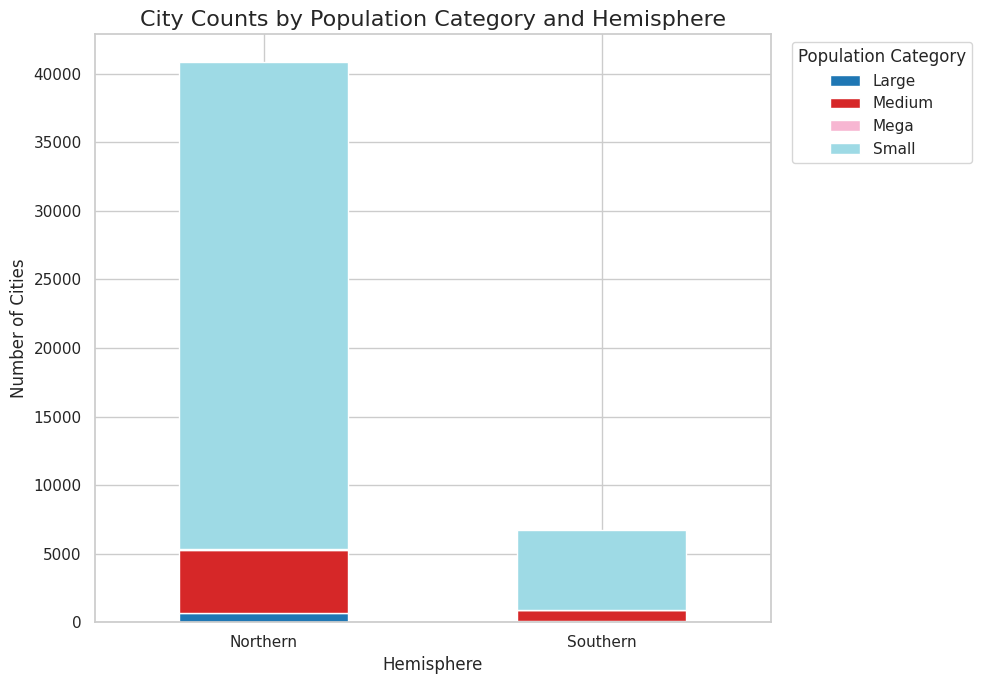

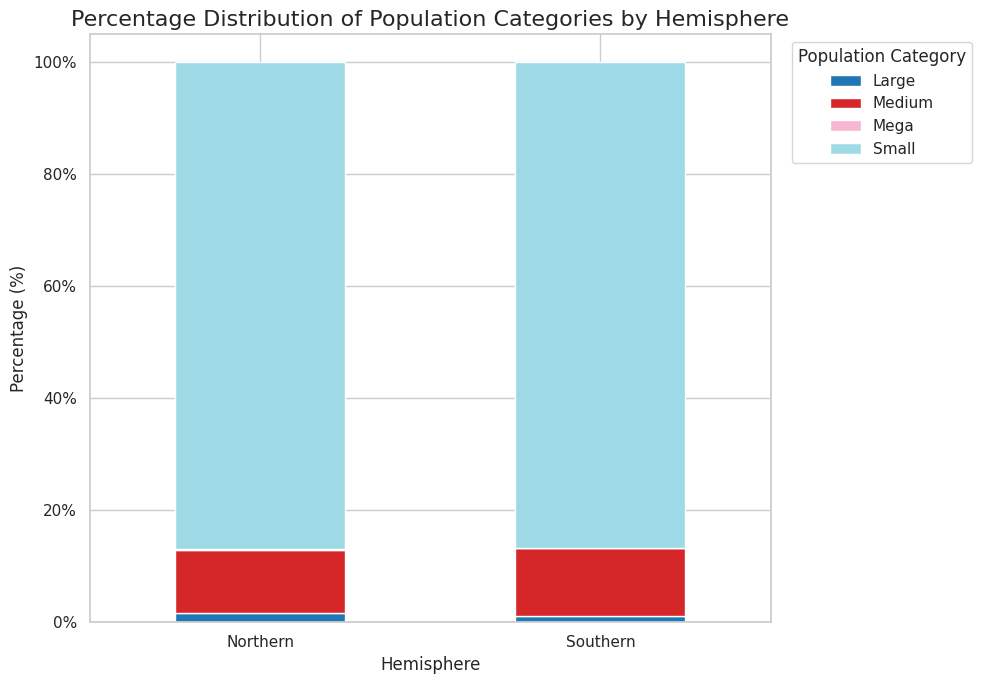

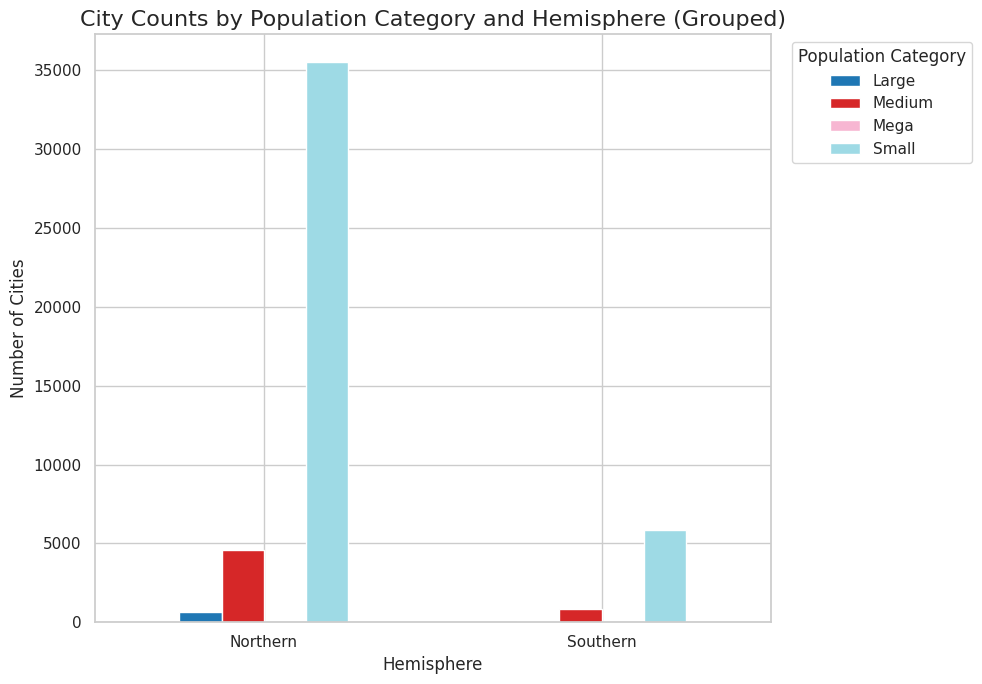

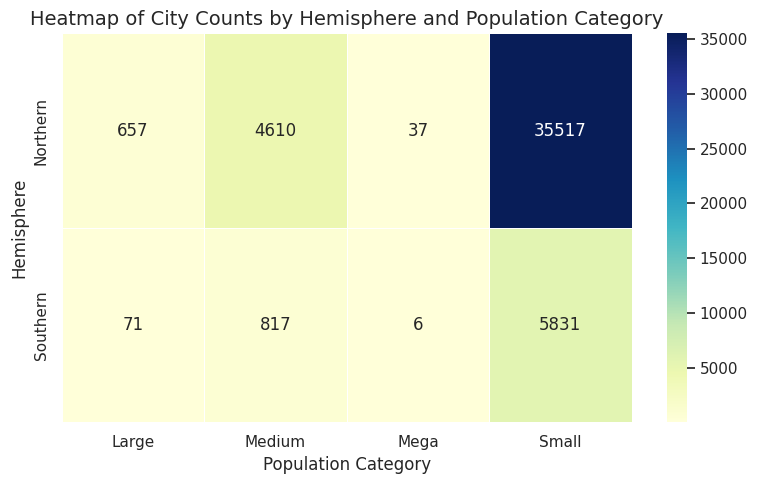

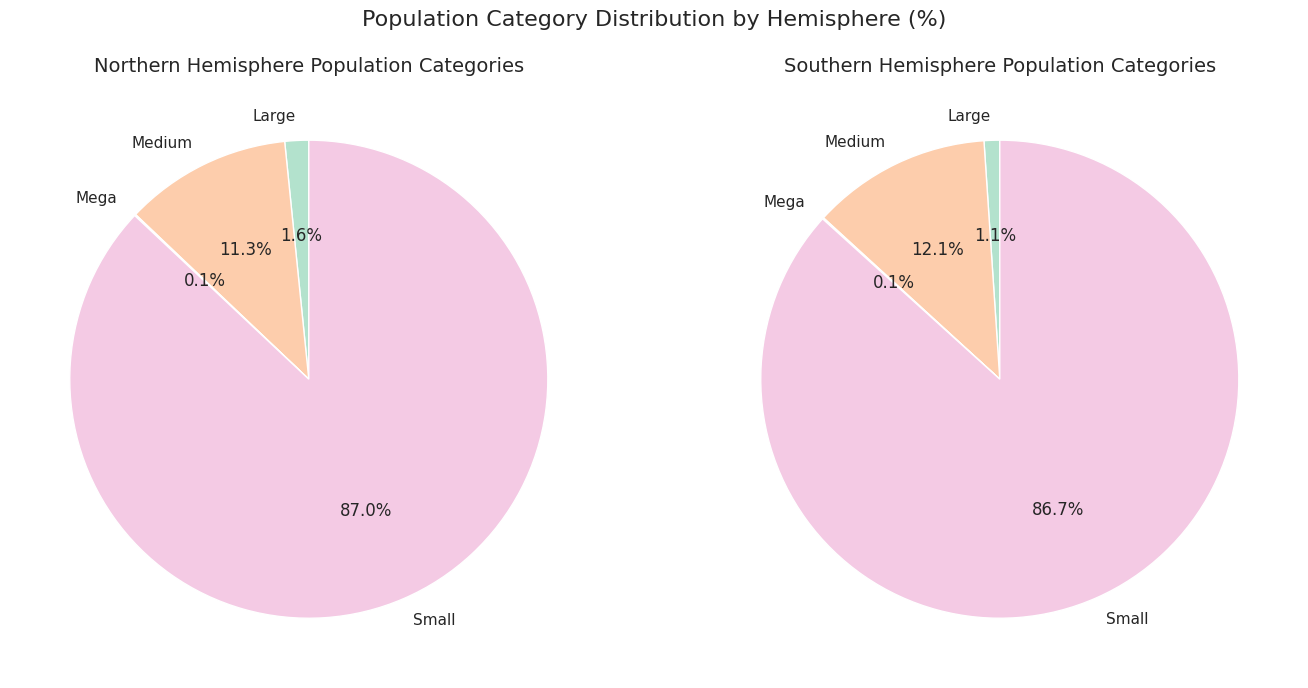

In [22]:
# --- Visualizations for Hemisphere Analysis ---
sns.set(style='whitegrid')

# 1. Stacked Bar Chart (Counts)
hemisphere_popcat_summary.plot(kind='bar', stacked=True, figsize=(10, 7), colormap='tab20')
plt.title('City Counts by Population Category and Hemisphere', fontsize=16)
plt.ylabel('Number of Cities', fontsize=12)
plt.xlabel('Hemisphere', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Population Category', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 2. Stacked Bar Chart (Percentages)
hemisphere_percentage_dist.plot(kind='bar', stacked=True, figsize=(10, 7), colormap='tab20')
plt.title('Percentage Distribution of Population Categories by Hemisphere', fontsize=16)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xlabel('Hemisphere', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Population Category', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y))) # Format y-axis as percentage
plt.tight_layout()
plt.show()

# 3. Grouped Bar Chart (Counts)
hemisphere_popcat_summary.plot(kind='bar', figsize=(10, 7), colormap='tab20')
plt.title('City Counts by Population Category and Hemisphere (Grouped)', fontsize=16)
plt.ylabel('Number of Cities', fontsize=12)
plt.xlabel('Hemisphere', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Population Category', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 4. Heatmap (Counts)
plt.figure(figsize=(8, 5))
sns.heatmap(hemisphere_popcat_summary, annot=True, fmt='.0f', cmap='YlGnBu', linewidths=.5)
plt.title('Heatmap of City Counts by Hemisphere and Population Category', fontsize=14)
plt.ylabel('Hemisphere', fontsize=12)
plt.xlabel('Population Category', fontsize=12)
plt.tight_layout()
plt.show()

# 5. Pie Charts (Percentage Distribution per Hemisphere)
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
colors = sns.color_palette('Pastel2', len(hemisphere_popcat_summary.columns))

# Northern Hemisphere Pie Chart
axes[0].pie(hemisphere_percentage_dist.loc['Northern'], labels=hemisphere_percentage_dist.columns, autopct='%1.1f%%', startangle=90, colors=colors)
axes[0].set_title('Northern Hemisphere Population Categories', fontsize=14)

# Southern Hemisphere Pie Chart
axes[1].pie(hemisphere_percentage_dist.loc['Southern'], labels=hemisphere_percentage_dist.columns, autopct='%1.1f%%', startangle=90, colors=colors)
axes[1].set_title('Southern Hemisphere Population Categories', fontsize=14)

plt.suptitle('Population Category Distribution by Hemisphere (%)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to prevent suptitle overlap
plt.show()

# Conclusion

This notebook successfully loaded, explored, cleaned, and visualized the world cities dataset.

**Key Steps:**
* **Data Loading & Exploration:** Initial understanding of data structure, types, and quality issues like missing values.
* **Data Cleaning:** Addressed missing data through imputation (specific, categorical, numeric using country averages, and geolocation for `admin_name`), handled duplicates, cleaned text fields, and removed irrelevant columns and zero-population cities.
* **Feature Engineering:** Created population categories and hemisphere information.
* **EDA & Visualization:** Analyzed distributions and relationships through summary statistics and various plots, including bar charts, interactive maps, heatmaps, and pie charts, highlighting top countries/cities and hemisphere differences.

The cleaned dataset (`cleaned_worldcities.csv`) and associated visualizations provide insights into the global distribution and population characteristics of cities.